In [30]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from IPython.core.display import display, HTML
from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the functions
import sys
sys.path.insert(1, '../src')
from preprocessing_eda import *

## 1. Reading and Storing Data

### Data Pre-processing

In [6]:
# Read the data
raw_data = pd.read_csv("../data/raw/ratings_Beauty.csv")

raw_data['Timestamp'] = raw_data['Timestamp'].apply(datetime.fromtimestamp)
raw_data.sort_values(by = "Timestamp", inplace = True)

In [10]:
# Store the dataframe as a picklefile for later use
if not os.path.isfile("../data/clean/RatingsBeauty.pkl"):
    raw_data.to_pickle("../data/clean/RatingsBeauty.pkl")
else:
    raw_data = pd.read_pickle("../data/clean/RatingsBeauty.pkl")

### First glance of the data

In [11]:
raw_data.head()

,UserId,ProductId,Rating,Timestamp
2297,A27ZIX4Y4A8M65,B000005J9Q,4.0,1998-10-18 17:00:00
2313,AXUC3MVPBT57K,B000005Z5L,5.0,1998-11-28 16:00:00
2334,A18XELRYWMR80B,B00000IAI4,5.0,1999-03-15 17:00:00
2416,A22S1QH6GDUE1V,B000026BTH,5.0,1999-06-02 17:00:00
2256,AUAZWQ8DULN43,B0000014DT,4.0,1999-09-13 17:00:00


In [12]:
raw_data.describe()

,Rating
count,2.023070e+06
mean,4.149036e+00
std,1.311505e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Check for NAs

In [17]:
print(f'Number of NAs:\n{raw_data.isnull().sum()}')

Number of NAs:
UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64


### Remove duplicates

In [19]:
duplicates = raw_data.duplicated(['UserId', 'ProductId', 'Rating'])
print(f'Number of duplicate rows: {duplicates.sum()}')

Number of duplicate rows: 0


### Some Statistics

In [20]:
num_users = len(set(raw_data['UserId']))
num_products = len(set(raw_data['ProductId']))
print("Number of ratings:", len(raw_data))
print("The average rating:", round(np.mean(raw_data["Rating"]),2))
print("Number of users:", num_users)
print("Number of items:", num_products)
print("Fraction nonzero:", len(raw_data)/(num_users*num_products))

Number of ratings: 2023070
The average rating: 4.15
Number of users: 1210271
Number of items: 249274
Fraction nonzero: 6.705810867006465e-06


### Split the data into training and test set (80-20)

In [23]:
df_train, df_test = train_test_split(raw_data, test_size=0.2, random_state=1115)

In [27]:
if not os.path.isfile("../data/clean/TrainData.pkl"):
    df_train.sort_values(by = "Timestamp", inplace = True)
    df_train.reset_index(drop = True, inplace = True)
    df_train.to_pickle("../data/clean/TrainData.pkl")
else:
    df_train = pd.read_pickle("../data/clean/TrainData.pkl")

if not os.path.isfile("../data/clean/TestData.pkl"):
    df_test.sort_values(by = "Timestamp", inplace = True)
    df_test.reset_index(drop = True, inplace = True)
    df_test.to_pickle("../data/clean/TestData.pkl")
else:
    df_test = pd.read_pickle("../data/clean/TestData.pkl")

## 2. EDA on training set

### Basic statistics

In [28]:
df_train.head()

,UserId,ProductId,Rating,Timestamp
0,A27ZIX4Y4A8M65,B000005J9Q,4.0,1998-10-18 17:00:00
1,AXUC3MVPBT57K,B000005Z5L,5.0,1998-11-28 16:00:00
2,A18XELRYWMR80B,B00000IAI4,5.0,1999-03-15 17:00:00
3,A22S1QH6GDUE1V,B000026BTH,5.0,1999-06-02 17:00:00
4,AUAZWQ8DULN43,B0000014DT,4.0,1999-09-13 17:00:00


In [29]:
num_users_train = len(set(df_train['UserId']))
num_products_train = len(set(df_train['ProductId']))
print("Number of ratings:", len(df_train))
print("The average rating:", round(np.mean(df_train["Rating"]),2))
print("Number of users:", num_users_train)
print("Number of items:", num_products_train)
print("Fraction nonzero:", len(df_train)/(num_users_train*num_products_train))
print("Size of full X matrix (GB):", round((num_users_train*num_products_train)*8/1e9, 2))

Number of ratings: 1618456
The average rating: 4.15
Number of users: 1025585
Number of items: 226779
Fraction nonzero: 6.958672551972826e-06
Size of full X matrix (GB): 1860.65


### Some Plots

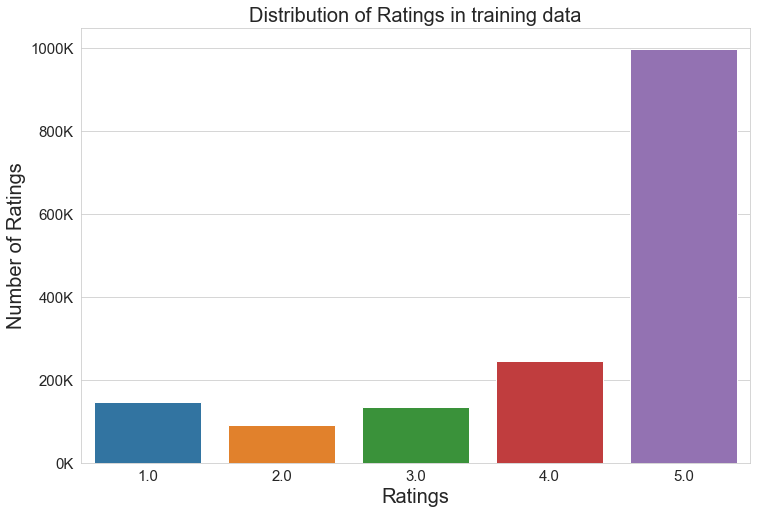

In [35]:
def changingLabels(number):
    return str(int(number/10**3)) + "K"

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Rating", data=df_train)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in training data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [81]:
df_train['DayofWeek'] = df_train.Timestamp.dt.weekday

In [85]:
def dayNameFromWeekday(weekday):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return days[weekday]

In [87]:
df_train['DayofWeek'] = df_train['DayofWeek'].apply(dayNameFromWeekday)

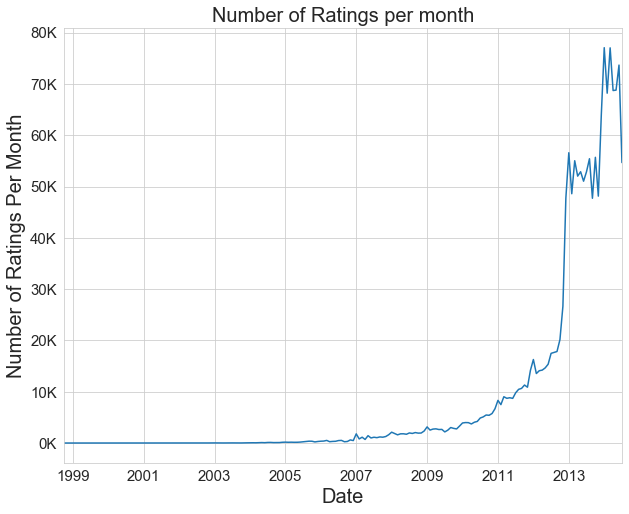

In [43]:
plt.figure(figsize = (10,8))
ax = df_train.resample("M", on = "Timestamp")["Rating"].count().plot()

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()


### Analysis of Users' Ratings

In [45]:
no_ratings_per_user = df_train.groupby(by = "UserId")["Rating"].count().sort_values(ascending = False)
no_ratings_per_user.head()

UserId
A3KEZLJ59C1JVH    305
A281NPSIMI1C2R    273
A3M174IC0VXOS2    260
ALQGOMOY1F5X9     230
A3LJLRIZL38GG3    225
Name: Rating, dtype: int64

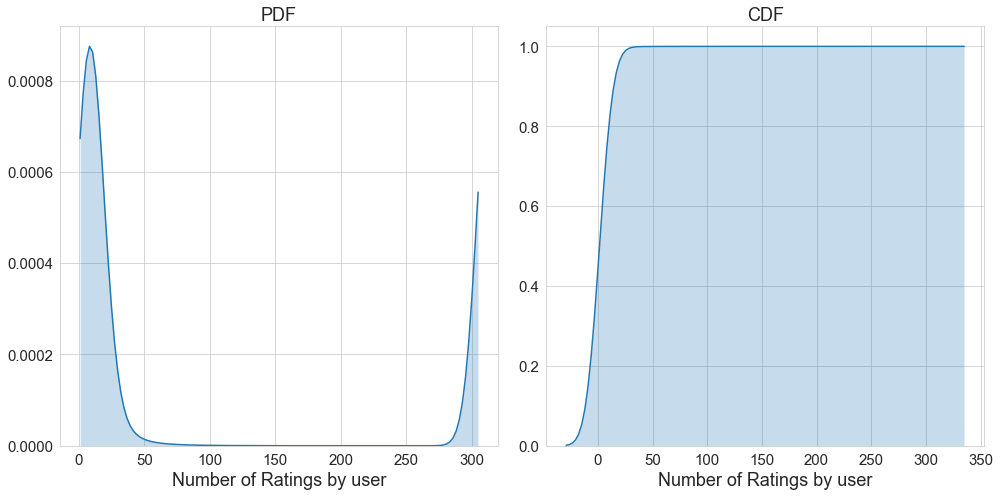

In [60]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_ratings_per_user.values, shade = True, ax = axes[0], bw=10, cut=0)
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_ratings_per_user.values, shade = True, cumulative = True, ax = axes[1], bw=10)
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

> The above plots shows that most users give very few ratings. And from the CDF plot, we can see that over 99% of users give less than 50 ratings.

In [59]:
print("Statistics of ratings grouped by users:")
no_ratings_per_user.describe()

Statistics of ratings grouped by users:


count    1.025585e+06
mean     1.578081e+00
std      2.178888e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.050000e+02
Name: Rating, dtype: float64

> A lot of users only give 1 rating, which makes recommendations even harder.

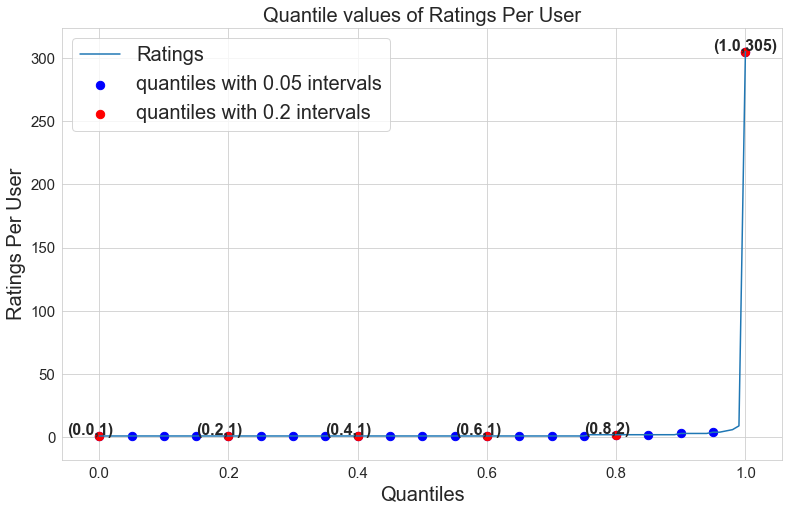

In [66]:
# Plot quantiles
quantiles = no_ratings_per_user.quantile(np.arange(0,1.01,0.01))

fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles, label='Ratings')

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::20], y = quantiles.values[::20], c = "red", s = 70, label="quantiles with 0.2 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::20], quantiles.values[::20]):
    plt.annotate(s = '({},{})'.format(x, int(y)), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+1))
    
axes.tick_params(labelsize = 15)

### Analysis ratings by item

In [70]:
no_ratings_per_item = df_train.groupby(by = "ProductId")["Rating"].count().sort_values(ascending = False)

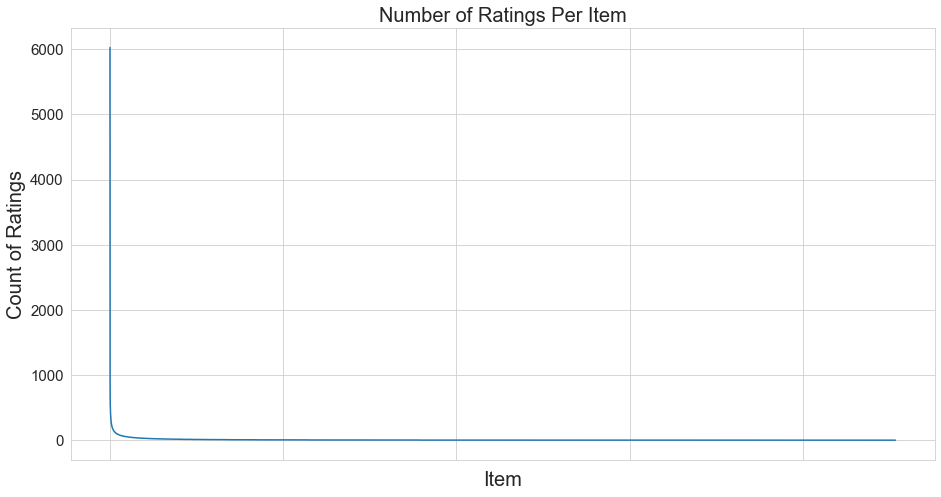

In [71]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Item", fontsize = 20)
plt.xlabel("Item", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_ratings_per_item.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

> As shown in the above plot, it is very skewed. Only a very few items are popular and were rated by many users.

### Analysis Ratings on Day of Week

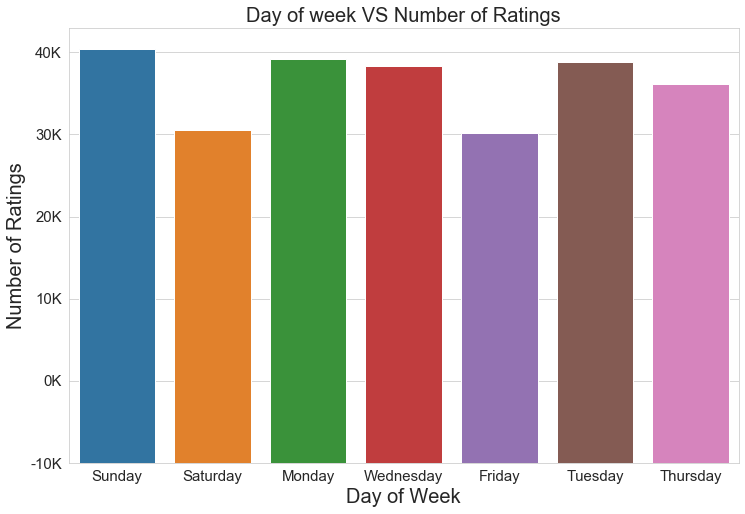

In [88]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayofWeek", data = df_train)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

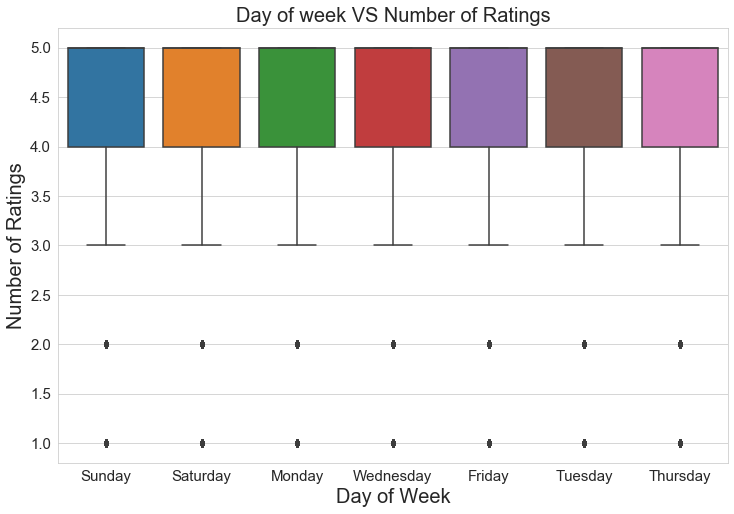

In [89]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "DayofWeek", y = "Rating", data = df_train)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [90]:
average_ratings_dayofweek = df_train.groupby(by = "DayofWeek")["Rating"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
DayofWeek
Friday       4.152607
Monday       4.147164
Saturday     4.148078
Sunday       4.145195
Thursday     4.154245
Tuesday      4.145942
Wednesday    4.147024
Name: Rating, dtype: float64
